In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

import optuna
import xgboost as xgb
import sklearn.datasets

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
class best_params():
    def __init__(self,train_x,train_y):
        self.train_x = train_x
        self.train_y = train_y
        
    def __call__(self,trial):
        X_train, X_val, y_train, y_val = train_test_split(
            self.train_x, self.train_y,test_size=0.2,shuffle=False)
        
        dtrain = xgb.DMatrix(X_train,label=y_train)
        dvalid = xgb.DMatrix(X_val,label=y_val)
        
        
        
        param = {
            "verbosity":0,
            "tree_method":"exact",
            "booster":trial.suggest_categorical("booster",["gbtree","gblinear","dart"]),
            "lambda":trial.suggest_float("lambda",1e-8,1.0,log=True),
            "alpha":trial.suggest_float("alpha",1e-8,1.0,log=True),
            "subsample":trial.suggest_float("subsample",0.2,1.0),
            "colsample_bytree":trial.suggest_float("colsample_bytree",0.2,1.0),
        }
        
        if param["booster"] in ["gbtree","dart"]:
            param["max_depth"] = trial.suggest_int("max_depth",3,10,step=1)
            param["min_child_weight"] = trial.suggest_float("min_child_weight",2,10)
            param["eta"] = trial.suggest_float("eta",1e-8,1.0,log=True)
            param["gamma"] = trial.suggest_float("gamma",1e-8,1.0,log=True)
            param["grow_policy"] = trial.suggest_categorical("grow_policy",["depthwise","lossguide"])
            
        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type",["uniform","weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type",["tree","forest"])
            param["rate_drop"] = trial.suggest_float("rate_drop",1e-8,1.0,log=True)
            param["skip_drop"] = trial.suggest_float("skip_drop",1e-8,1.0,log=True)
            
        bst = xgb.train(param,dtrain)
        preds = bst.predict(dvalid)
        mse = mean_squared_error(y_val,preds)
        
        return mse        

In [4]:
def get_estimator(train_x,train_y):
    
    study = optuna.create_study(direction="minimize",)
    study.optimize(best_params(train_x,train_y),n_trials=100)
    
    
#     x_train,x_val,y_train,y_val = train_test_split(train_x,train_y,test_size=0.2,shuffle=False)
#     gbrt = GradientBoostingRegressor(max_depth=3,n_estimators=100)
#     gbrt.fit(x_train,y_train)
    
#     errors = [mean_squared_error(y_val, predict_y)
#              for predict_y in gbrt.staged_predict(x_val)]
#     best_n_estimators = np.argmin(errors)+1
    
    return study.best_params

In [5]:
def fit_method(total_x,total_y):
    X_train, X_test, y_train, y_test = train_test_split(total_x, total_y, 
                                                        test_size=0.2,shuffle=False)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    param = get_estimator(X_train,y_train)
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dtest = xgb.DMatrix(X_test,label=y_test)
    
    bst = xgb.train(param,dtrain)
    predictions = bst.predict(dtest)
    
#     gbrt_best = GradientBoostingRegressor(max_depth=param['max_depth'],
#                                           n_estimators=param['n_estimators'])
#     gbrt_best.fit(X_train,y_train)
    
#     predictions = gbrt_best.predict(X_test)
#     print(predictions.shape)
#     print(y_test.shape)
#     print(scaler.inverse_transform(X_test).reshape(-1).shape)
    
    return y_test,predictions, scaler.inverse_transform(X_test).reshape(-1)

## Forecasting 

In [6]:
op = [25,40,50,75]
dy = [10,20,30,40,50, 60, 70, 80, 91] # for forward year

In [7]:
result = {'actual':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'predictions':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []}}

total_x = np.linspace(1901,2014,114).reshape(-1,1)
data = pd.read_csv('Optimal_averaging_using_ensemble_entire_set.dat',sep='\s+',header=None)

for i in range(9):
    total_y = data.iloc[i].values.reshape(114,)
    actual,predicted, _ = fit_method(total_x,total_y)
    result['actual'][str(dy[i])+' years'] = actual
    result['predictions'][str(dy[i])+' years'] = predicted

[I 2023-11-17 14:02:12,769] A new study created in memory with name: no-name-59e1685e-1405-4977-8cb4-93efc9901274
[I 2023-11-17 14:02:12,832] Trial 0 finished with value: 0.466260813028184 and parameters: {'booster': 'gbtree', 'lambda': 0.2757596594202911, 'alpha': 0.08776574816063219, 'subsample': 0.48598885921089174, 'colsample_bytree': 0.35750132991534944, 'max_depth': 9, 'min_child_weight': 4.4541846747286975, 'eta': 4.003623521068194e-05, 'gamma': 5.467464582172347e-05, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.466260813028184.
[I 2023-11-17 14:02:12,854] Trial 1 finished with value: 0.4841891901499782 and parameters: {'booster': 'gblinear', 'lambda': 5.818334419529867e-06, 'alpha': 4.627559992656712e-07, 'subsample': 0.9173149031363421, 'colsample_bytree': 0.5382709237369923}. Best is trial 0 with value: 0.466260813028184.
[I 2023-11-17 14:02:12,871] Trial 2 finished with value: 0.48414513415593907 and parameters: {'booster': 'gblinear', 'lambda': 0.0009898137307

[I 2022-10-02 01:05:05,658] Trial 77 finished with value: 0.41187778354120863 and parameters: {'booster': 'gblinear', 'lambda': 0.24405476756259795, 'alpha': 9.649240020423253e-08, 'subsample': 0.9170158448935574, 'colsample_bytree': 0.7345437605085994}. Best is trial 44 with value: 0.41159353731301396.
[I 2022-10-02 01:05:05,693] Trial 78 finished with value: 0.4119386145957948 and parameters: {'booster': 'gblinear', 'lambda': 0.0026200616097404664, 'alpha': 2.3959962440772618e-08, 'subsample': 0.754714155819078, 'colsample_bytree': 0.9017534993377181}. Best is trial 44 with value: 0.41159353731301396.
[I 2022-10-02 01:05:05,725] Trial 79 finished with value: 0.41165263077643083 and parameters: {'booster': 'gblinear', 'lambda': 0.1662521267445656, 'alpha': 6.004524865257323e-08, 'subsample': 0.8833804753670131, 'colsample_bytree': 0.6821054987578797}. Best is trial 44 with value: 0.41159353731301396.
[I 2022-10-02 01:05:05,749] Trial 80 finished with value: 0.41173048484870334 and par

[I 2022-10-02 01:05:06,275] Trial 1 finished with value: 47.13153151741493 and parameters: {'booster': 'dart', 'lambda': 1.546752403449709e-06, 'alpha': 5.749073509171516e-07, 'subsample': 0.9250737951304191, 'colsample_bytree': 0.9470449946597139, 'max_depth': 7, 'min_child_weight': 2.9716670462934287, 'eta': 3.6260011968658377e-06, 'gamma': 1.1975280481990073e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.0473762179434018e-07, 'skip_drop': 2.2346237487718682e-08}. Best is trial 0 with value: 31.372383306464336.
[I 2022-10-02 01:05:06,291] Trial 2 finished with value: 47.12537201079269 and parameters: {'booster': 'dart', 'lambda': 8.589132254067803e-05, 'alpha': 1.6559602681145433e-05, 'subsample': 0.7199757309697414, 'colsample_bytree': 0.43685785841663566, 'max_depth': 8, 'min_child_weight': 2.708598631303114, 'eta': 1.0652776201916353e-05, 'gamma': 0.0003201792211273464, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'nor

[I 2022-10-02 01:05:06,688] Trial 22 finished with value: 0.4246089441044745 and parameters: {'booster': 'gblinear', 'lambda': 0.05754083966410167, 'alpha': 7.305323114069845e-05, 'subsample': 0.9944683216638175, 'colsample_bytree': 0.3078199589151399}. Best is trial 6 with value: 0.42453907850087186.
[I 2022-10-02 01:05:06,722] Trial 23 finished with value: 0.42453650168564916 and parameters: {'booster': 'gblinear', 'lambda': 0.149234964245568, 'alpha': 0.00012713140514195568, 'subsample': 0.9897760946567892, 'colsample_bytree': 0.2854993368946359}. Best is trial 23 with value: 0.42453650168564916.
[I 2022-10-02 01:05:06,753] Trial 24 finished with value: 0.4245325675029445 and parameters: {'booster': 'gblinear', 'lambda': 0.15943772966735592, 'alpha': 9.616307520033151e-05, 'subsample': 0.9748132494258728, 'colsample_bytree': 0.40033063690171755}. Best is trial 24 with value: 0.4245325675029445.
[I 2022-10-02 01:05:06,778] Trial 25 finished with value: 0.42455373615657654 and paramet

[I 2022-10-02 01:05:07,350] Trial 45 finished with value: 0.42457256822143097 and parameters: {'booster': 'gblinear', 'lambda': 0.07518267027874784, 'alpha': 6.757904072975661e-05, 'subsample': 0.8520240151511516, 'colsample_bytree': 0.3762765285951971}. Best is trial 24 with value: 0.4245325675029445.
[I 2022-10-02 01:05:07,394] Trial 46 finished with value: 24.801683893030113 and parameters: {'booster': 'gbtree', 'lambda': 0.6305473974159838, 'alpha': 9.311267999527285e-07, 'subsample': 0.29458888673576666, 'colsample_bytree': 0.2387688062930675, 'max_depth': 6, 'min_child_weight': 6.404872108162098, 'eta': 0.03356863755819495, 'gamma': 0.00015011235996880183, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.4245325675029445.
[I 2022-10-02 01:05:07,422] Trial 47 finished with value: 0.4258815396252828 and parameters: {'booster': 'gblinear', 'lambda': 0.031060850923524987, 'alpha': 0.004637715280175993, 'subsample': 0.9660672539220049, 'colsample_bytree': 0.2042973491404581

[I 2022-10-02 01:05:08,021] Trial 69 finished with value: 0.42462281911917094 and parameters: {'booster': 'gblinear', 'lambda': 0.2533077380388393, 'alpha': 6.840947402338565e-05, 'subsample': 0.7139545503967262, 'colsample_bytree': 0.7248046085969616}. Best is trial 65 with value: 0.4245160719037492.
[I 2022-10-02 01:05:08,039] Trial 70 finished with value: 0.42458962690280583 and parameters: {'booster': 'gblinear', 'lambda': 0.058646814543041145, 'alpha': 3.0794362180121837e-06, 'subsample': 0.6616457486257021, 'colsample_bytree': 0.4014834575963227}. Best is trial 65 with value: 0.4245160719037492.
[I 2022-10-02 01:05:08,068] Trial 71 finished with value: 0.4245278201503126 and parameters: {'booster': 'gblinear', 'lambda': 0.10504929622617146, 'alpha': 3.17591713979123e-05, 'subsample': 0.45385841772378, 'colsample_bytree': 0.47549460647703}. Best is trial 65 with value: 0.4245160719037492.
[I 2022-10-02 01:05:08,086] Trial 72 finished with value: 0.4245319652988994 and parameters: 

[I 2022-10-02 01:05:08,697] Trial 94 finished with value: 0.42458126395373863 and parameters: {'booster': 'gblinear', 'lambda': 0.06214599406703749, 'alpha': 2.3310305055092605e-07, 'subsample': 0.53381411215167, 'colsample_bytree': 0.655900601701432}. Best is trial 82 with value: 0.4245083906876869.
[I 2022-10-02 01:05:08,725] Trial 95 finished with value: 0.424718669549973 and parameters: {'booster': 'gblinear', 'lambda': 0.3144919635640061, 'alpha': 1.2826627362617094e-07, 'subsample': 0.5604025773368285, 'colsample_bytree': 0.6858942935774334}. Best is trial 82 with value: 0.4245083906876869.
[I 2022-10-02 01:05:08,757] Trial 96 finished with value: 0.42546822536331347 and parameters: {'booster': 'gblinear', 'lambda': 0.6266211576500712, 'alpha': 3.7937996932400955e-08, 'subsample': 0.5979169283044008, 'colsample_bytree': 0.7648490312505847}. Best is trial 82 with value: 0.4245083906876869.
[I 2022-10-02 01:05:08,774] Trial 97 finished with value: 0.4245115195144242 and parameters:

[I 2022-10-02 01:05:09,128] Trial 14 finished with value: 0.4466218380701974 and parameters: {'booster': 'gblinear', 'lambda': 6.682660158043725e-06, 'alpha': 6.756570438080274e-07, 'subsample': 0.6050588378847953, 'colsample_bytree': 0.33183048110457186}. Best is trial 14 with value: 0.4466218380701974.
[I 2022-10-02 01:05:09,152] Trial 15 finished with value: 0.4466232007589668 and parameters: {'booster': 'gblinear', 'lambda': 2.114736001778178e-05, 'alpha': 3.701878437153964e-05, 'subsample': 0.5718240699560686, 'colsample_bytree': 0.33212219001095683}. Best is trial 14 with value: 0.4466218380701974.
[I 2022-10-02 01:05:09,168] Trial 16 finished with value: 0.4466218015816963 and parameters: {'booster': 'gblinear', 'lambda': 1.0258258205882408e-08, 'alpha': 3.182638031576173e-07, 'subsample': 0.6886512235232825, 'colsample_bytree': 0.4401224968130244}. Best is trial 16 with value: 0.4466218015816963.
[I 2022-10-02 01:05:09,200] Trial 17 finished with value: 46.46731557845549 and pa

[I 2022-10-02 01:05:09,784] Trial 38 finished with value: 46.46712957435722 and parameters: {'booster': 'dart', 'lambda': 0.0002682959775432547, 'alpha': 3.011878120973957e-08, 'subsample': 0.6282848142570696, 'colsample_bytree': 0.7737282574724519, 'max_depth': 8, 'min_child_weight': 3.6127369230155457, 'eta': 4.0161222679358245e-07, 'gamma': 3.423954015564275e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.5407904145749648, 'skip_drop': 0.0005980891843701893}. Best is trial 37 with value: 0.4466214178652137.
[I 2022-10-02 01:05:09,810] Trial 39 finished with value: 0.44662098000186007 and parameters: {'booster': 'gblinear', 'lambda': 0.0006047426407522405, 'alpha': 2.369122468160451e-05, 'subsample': 0.5624766306676255, 'colsample_bytree': 0.5349987540745933}. Best is trial 39 with value: 0.44662098000186007.
[I 2022-10-02 01:05:09,864] Trial 40 finished with value: 46.349963550499524 and parameters: {'booster': 'dart', 'lambda': 0

[I 2022-10-02 01:05:10,508] Trial 61 finished with value: 0.4463268261111186 and parameters: {'booster': 'gblinear', 'lambda': 0.26331306933681, 'alpha': 0.0013287496201032547, 'subsample': 0.2623646620565157, 'colsample_bytree': 0.9488088792620446}. Best is trial 61 with value: 0.4463268261111186.
[I 2022-10-02 01:05:10,535] Trial 62 finished with value: 0.44633930089401536 and parameters: {'booster': 'gblinear', 'lambda': 0.22074505654669213, 'alpha': 0.001057643536641553, 'subsample': 0.2634821886292318, 'colsample_bytree': 0.9369104750373283}. Best is trial 61 with value: 0.4463268261111186.
[I 2022-10-02 01:05:10,553] Trial 63 finished with value: 0.4466042390699573 and parameters: {'booster': 'gblinear', 'lambda': 0.2740917886525816, 'alpha': 0.006979007928106931, 'subsample': 0.20077354816441337, 'colsample_bytree': 0.9374323410446828}. Best is trial 61 with value: 0.4463268261111186.
[I 2022-10-02 01:05:10,571] Trial 64 finished with value: 0.4485748967402506 and parameters: {'

[I 2022-10-02 01:05:11,179] Trial 86 finished with value: 0.4462414446633627 and parameters: {'booster': 'gblinear', 'lambda': 0.5442610524361536, 'alpha': 4.152368445468767e-05, 'subsample': 0.33781403087365075, 'colsample_bytree': 0.9813328258659565}. Best is trial 85 with value: 0.4462379370712828.
[I 2022-10-02 01:05:11,203] Trial 87 finished with value: 0.44624540160592324 and parameters: {'booster': 'gblinear', 'lambda': 0.595141386012479, 'alpha': 5.828518228527728e-06, 'subsample': 0.4117938446528251, 'colsample_bytree': 0.9830886135537206}. Best is trial 85 with value: 0.4462379370712828.
[I 2022-10-02 01:05:11,262] Trial 88 finished with value: 46.44492985492419 and parameters: {'booster': 'dart', 'lambda': 0.600302661096553, 'alpha': 4.074206593325718e-06, 'subsample': 0.4278859094427757, 'colsample_bytree': 0.9807929911286392, 'max_depth': 9, 'min_child_weight': 7.461262400862779, 'eta': 2.5034609343165455e-05, 'gamma': 3.295704915268577e-07, 'grow_policy': 'depthwise', 'sa

## Error_prediction

In [8]:
# cn_bar - ck_bar
error_actual = {'500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'800 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1000 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []}}
# \hat_cn_bar-\hat_ck_bar
error_prediction = {'500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'800 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1000 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []}}
est_spa_bc = {'500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'800 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1000 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []}}

In [9]:
# Xgboost fit to erorr compared with the entire set 
# input-->OA, output-->error

for i in op:
    print('optimal_locations:',i)
    error_data = pd.read_csv('Error_Optimal_averaging_using_ensemble_'+str(20*i)+'_locations.dat',sep='\s+',header=None)
    OA_data = pd.read_csv('Optimal_averaging_using_ensemble_'+str(20*i)+'_locations.dat',sep ='\s+',header=None)

    for k in range(9):
        total_x = OA_data.iloc[k].values.reshape(-1,1)
        assert(total_x.shape==(114,1))
        total_y = error_data.iloc[k].values.reshape(114,)
        assert(total_y.shape==(114,))
        actual, predicted, inputs = fit_method(total_x,total_y)
        assert(actual.shape==(23,))
        assert(predicted.shape==(23,))
        assert(inputs.shape==(23,))
        error_actual[str(20*i)+' locations'][str(dy[k])+' years'] = actual
        error_prediction[str(20*i)+' locations'][str(dy[k])+' years'] = predicted
        est_spa_bc[str(20*i)+' locations'][str(dy[k])+' years'] = inputs

[I 2023-11-17 14:04:03,766] A new study created in memory with name: no-name-37b41076-aca1-4409-8238-c8dd9eb62362
[I 2023-11-17 14:04:03,804] Trial 0 finished with value: 0.1374584427772734 and parameters: {'booster': 'gblinear', 'lambda': 2.8306979821537307e-07, 'alpha': 0.007517687222741878, 'subsample': 0.9221668798409177, 'colsample_bytree': 0.5226365432900668}. Best is trial 0 with value: 0.1374584427772734.
[I 2023-11-17 14:04:03,815] Trial 1 finished with value: 0.13568076794069847 and parameters: {'booster': 'dart', 'lambda': 0.035715333329075914, 'alpha': 0.0005131748756210013, 'subsample': 0.2813747619905641, 'colsample_bytree': 0.2049517829647085, 'max_depth': 3, 'min_child_weight': 8.717436122148776, 'eta': 5.054894827896926e-06, 'gamma': 9.857204836520877e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0014893546596209902, 'skip_drop': 1.6021697384207555e-07}. Best is trial 1 with value: 0.13568076794069847.
[I 2023-11-17

optimal_locations: 25


[I 2023-11-17 14:04:03,964] Trial 8 finished with value: 0.1369051805524696 and parameters: {'booster': 'gblinear', 'lambda': 1.0846732336264243e-08, 'alpha': 0.01297891259404927, 'subsample': 0.7126281583607581, 'colsample_bytree': 0.5797650229800682}. Best is trial 6 with value: 0.13320322107433538.
[I 2023-11-17 14:04:03,973] Trial 9 finished with value: 0.13568049474621696 and parameters: {'booster': 'dart', 'lambda': 0.000741596647366545, 'alpha': 0.002112743534966189, 'subsample': 0.9721156156290753, 'colsample_bytree': 0.7907990244674683, 'max_depth': 7, 'min_child_weight': 9.507899742473885, 'eta': 2.2951868203231275e-06, 'gamma': 5.501481580986226e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.336220590528579e-08, 'skip_drop': 0.007119106559024964}. Best is trial 6 with value: 0.13320322107433538.
[I 2023-11-17 14:04:04,019] Trial 10 finished with value: 0.1315382444808941 and parameters: {'booster': 'dart', 'lambda': 0.001

optimal_locations: 40


[I 2023-11-17 14:05:05,274] Trial 2 finished with value: 0.12748597810029363 and parameters: {'booster': 'gblinear', 'lambda': 0.0065928468034576115, 'alpha': 8.183110460891076e-06, 'subsample': 0.7386284651578507, 'colsample_bytree': 0.2072865427686156}. Best is trial 1 with value: 0.12051273614929428.
[I 2023-11-17 14:05:05,330] Trial 3 finished with value: 0.12048651167427336 and parameters: {'booster': 'dart', 'lambda': 0.01175751525016845, 'alpha': 5.414690941033188e-07, 'subsample': 0.4933285058761593, 'colsample_bytree': 0.9352884314505339, 'max_depth': 4, 'min_child_weight': 5.358571890008345, 'eta': 5.564087529358798e-07, 'gamma': 0.00016624380715197395, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0007789472629245725, 'skip_drop': 0.024817378363389066}. Best is trial 3 with value: 0.12048651167427336.
[I 2023-11-17 14:05:05,420] Trial 4 finished with value: 0.12533206617949855 and parameters: {'booster': 'gblinear', 'lambda'

optimal_locations: 50


[I 2023-11-17 14:06:12,229] Trial 4 finished with value: 0.11790802347395427 and parameters: {'booster': 'dart', 'lambda': 1.04417705855698e-05, 'alpha': 1.2962567621895658e-06, 'subsample': 0.950422120929378, 'colsample_bytree': 0.6244012845713132, 'max_depth': 7, 'min_child_weight': 5.27876778538077, 'eta': 0.05980069559771327, 'gamma': 7.2912513356683125e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.6923202399626163, 'skip_drop': 2.533972810253148e-06}. Best is trial 0 with value: 0.11182954622498983.
[I 2023-11-17 14:06:12,326] Trial 5 finished with value: 0.11182961699757361 and parameters: {'booster': 'gbtree', 'lambda': 0.15018910083679513, 'alpha': 1.2262939362835414e-07, 'subsample': 0.9173292512552969, 'colsample_bytree': 0.3494477398408137, 'max_depth': 6, 'min_child_weight': 2.8618474836029995, 'eta': 4.776907375090394e-08, 'gamma': 0.18850019897409734, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.111829546

optimal_locations: 75


[I 2023-11-17 14:07:15,831] Trial 4 finished with value: 0.08876401468116443 and parameters: {'booster': 'gblinear', 'lambda': 5.822850127905974e-07, 'alpha': 6.650355641899638e-06, 'subsample': 0.20427948094040949, 'colsample_bytree': 0.3022062567308827}. Best is trial 2 with value: 0.08815243684429454.
[I 2023-11-17 14:07:15,835] Trial 5 finished with value: 0.08846675925439439 and parameters: {'booster': 'gblinear', 'lambda': 0.5180951195648222, 'alpha': 0.001289936984842343, 'subsample': 0.914952425036389, 'colsample_bytree': 0.8294491947433209}. Best is trial 2 with value: 0.08815243684429454.
[I 2023-11-17 14:07:15,945] Trial 6 finished with value: 0.08815240998721759 and parameters: {'booster': 'dart', 'lambda': 0.0006531937491374081, 'alpha': 0.7298611250104237, 'subsample': 0.47666594353514385, 'colsample_bytree': 0.9054189478722243, 'max_depth': 7, 'min_child_weight': 8.010695786259024, 'eta': 9.344735586098331e-08, 'gamma': 0.003722035265216999, 'grow_policy': 'lossguide', '

[I 2022-10-02 01:06:04,661] Trial 99 finished with value: 0.26256044148064533 and parameters: {'booster': 'gbtree', 'lambda': 3.096245524564394e-06, 'alpha': 1.806819053041784e-07, 'subsample': 0.3056211055288017, 'colsample_bytree': 0.2693125335592014, 'max_depth': 3, 'min_child_weight': 5.983181187181634, 'eta': 0.427929897826982, 'gamma': 1.2679514806856024e-06, 'grow_policy': 'lossguide'}. Best is trial 27 with value: 0.115936426961696.
/home/sumanth/anaconda3/envs/torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)
[I 2022-10-02 01:06:04,689] A new study created in memory with name: no-name-a8251663-add1-4e37-bae2-4e51865d4f2f
[I 2022-10-02 01:06:04,700] Trial 0 finished with value: 0.30637415404579116 and parameters: {'booster': 'gbtree', 'lambda': 8.70534610854073e-06, 'a

optimal_locations: 75


[I 2022-10-02 01:06:04,883] Trial 11 finished with value: 0.08801425795055112 and parameters: {'booster': 'gblinear', 'lambda': 0.004191085804832852, 'alpha': 0.007475352814953577, 'subsample': 0.6148302465994269, 'colsample_bytree': 0.22949625556637604}. Best is trial 10 with value: 0.08780055583849307.
[I 2022-10-02 01:06:04,913] Trial 12 finished with value: 0.08783953482486162 and parameters: {'booster': 'gblinear', 'lambda': 0.005324466546856696, 'alpha': 0.011893785787744965, 'subsample': 0.5759222190805934, 'colsample_bytree': 0.20434022550730815}. Best is trial 10 with value: 0.08780055583849307.
[I 2022-10-02 01:06:04,931] Trial 13 finished with value: 0.08793827882566933 and parameters: {'booster': 'gblinear', 'lambda': 0.006588014217881591, 'alpha': 0.009257931440445283, 'subsample': 0.590102568174104, 'colsample_bytree': 0.21947505580293036}. Best is trial 10 with value: 0.08780055583849307.
[I 2022-10-02 01:06:04,948] Trial 14 finished with value: 0.08779294190196105 and p

[I 2022-10-02 01:06:05,605] Trial 36 finished with value: 0.17684926012413676 and parameters: {'booster': 'gbtree', 'lambda': 0.2893628758174702, 'alpha': 9.587443457200246e-08, 'subsample': 0.6425168497319627, 'colsample_bytree': 0.4516375549169358, 'max_depth': 8, 'min_child_weight': 2.3242722771909317, 'eta': 0.793109886653602, 'gamma': 3.0058804157745228e-06, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.08779294190196105.
[I 2022-10-02 01:06:05,632] Trial 37 finished with value: 0.08838232833394202 and parameters: {'booster': 'gblinear', 'lambda': 0.001720263975444545, 'alpha': 0.0004220917961660098, 'subsample': 0.5065249079656919, 'colsample_bytree': 0.5101140168272403}. Best is trial 14 with value: 0.08779294190196105.
[I 2022-10-02 01:06:05,685] Trial 38 finished with value: 0.30579830795374063 and parameters: {'booster': 'dart', 'lambda': 0.022244464215133077, 'alpha': 0.07925695977121028, 'subsample': 0.7442696723108878, 'colsample_bytree': 0.6636397388612559, 

[I 2022-10-02 01:06:06,296] Trial 54 finished with value: 0.05083511582738737 and parameters: {'booster': 'dart', 'lambda': 1.0118227653051341e-08, 'alpha': 0.5020131578035844, 'subsample': 0.9884213275349998, 'colsample_bytree': 0.9696609514404236, 'max_depth': 9, 'min_child_weight': 5.475432655100412, 'eta': 0.1350043310331441, 'gamma': 0.1361888945810281, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.7362672682263313e-05, 'skip_drop': 0.0008008065746252615}. Best is trial 49 with value: 0.03376153638133515.
[I 2022-10-02 01:06:06,345] Trial 55 finished with value: 0.06177763029956923 and parameters: {'booster': 'dart', 'lambda': 6.594330291780608e-08, 'alpha': 0.5494957020844843, 'subsample': 0.9553224235083849, 'colsample_bytree': 0.9934601307331447, 'max_depth': 9, 'min_child_weight': 4.472623969574725, 'eta': 0.16366138387332077, 'gamma': 0.09870780546686968, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': '

[I 2022-10-02 01:06:07,039] Trial 69 finished with value: 0.04489672269401356 and parameters: {'booster': 'dart', 'lambda': 2.2528941832691505e-08, 'alpha': 0.9844683818590974, 'subsample': 0.8595562855153933, 'colsample_bytree': 0.920923540623407, 'max_depth': 9, 'min_child_weight': 4.552279623301847, 'eta': 0.1274495337144565, 'gamma': 0.3199963967256035, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.3321663460161567e-07, 'skip_drop': 8.109974489768321e-05}. Best is trial 49 with value: 0.03376153638133515.
[I 2022-10-02 01:06:07,089] Trial 70 finished with value: 0.09669966768736747 and parameters: {'booster': 'dart', 'lambda': 2.4841736324491165e-07, 'alpha': 2.345349201386584e-06, 'subsample': 0.860765660490916, 'colsample_bytree': 0.9212812190515001, 'max_depth': 8, 'min_child_weight': 4.523248645444863, 'eta': 0.3032140995687764, 'gamma': 0.2865951118448794, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': '

[I 2022-10-02 01:06:07,805] Trial 84 finished with value: 0.10754872142662741 and parameters: {'booster': 'dart', 'lambda': 2.1363120927963566e-08, 'alpha': 0.1410935918930986, 'subsample': 0.9686402221765748, 'colsample_bytree': 0.9463934622183952, 'max_depth': 10, 'min_child_weight': 3.8626724547082616, 'eta': 0.49255692450509353, 'gamma': 0.43706213912611314, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.734635047699729e-07, 'skip_drop': 0.0001271734562829305}. Best is trial 49 with value: 0.03376153638133515.
[I 2022-10-02 01:06:07,847] Trial 85 finished with value: 0.3032836378448193 and parameters: {'booster': 'gbtree', 'lambda': 1.3283321129469087e-07, 'alpha': 9.565738432179277e-06, 'subsample': 0.8302430409421888, 'colsample_bytree': 0.9806871886684128, 'max_depth': 8, 'min_child_weight': 3.3499267853109833, 'eta': 0.0003980853240916608, 'gamma': 0.15634159113543658, 'grow_policy': 'depthwise'}. Best is trial 49 with value: 0.03

[I 2022-10-02 01:06:08,587] Trial 99 finished with value: 0.0985729641619114 and parameters: {'booster': 'dart', 'lambda': 7.969276434417691e-07, 'alpha': 0.7102803510345495, 'subsample': 0.9533142455716501, 'colsample_bytree': 0.8935545218913461, 'max_depth': 10, 'min_child_weight': 4.039303433731321, 'eta': 0.04738429649989429, 'gamma': 0.10675125424670633, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.0766874913335772e-06, 'skip_drop': 0.0017849112654093366}. Best is trial 49 with value: 0.03376153638133515.
[I 2022-10-02 01:06:08,604] A new study created in memory with name: no-name-422163e1-1ffb-4893-96ee-8a90a5342069
[I 2022-10-02 01:06:08,612] Trial 0 finished with value: 0.9482923576712374 and parameters: {'booster': 'dart', 'lambda': 0.00010271638289357642, 'alpha': 0.05375870416133147, 'subsample': 0.649273674799028, 'colsample_bytree': 0.5130293218446891, 'max_depth': 5, 'min_child_weight': 9.390049984960342, 'eta': 1.19892020

[I 2022-10-02 01:06:09,034] Trial 18 finished with value: 0.12293307159214839 and parameters: {'booster': 'gblinear', 'lambda': 3.863806397248313e-06, 'alpha': 0.957346873358398, 'subsample': 0.5090642116187456, 'colsample_bytree': 0.5815221110585382}. Best is trial 17 with value: 0.12293307159214839.
[I 2022-10-02 01:06:09,051] Trial 19 finished with value: 0.12293307159214839 and parameters: {'booster': 'gblinear', 'lambda': 4.8179568305239625e-06, 'alpha': 0.8465657011862692, 'subsample': 0.5245761382931831, 'colsample_bytree': 0.6184150221863906}. Best is trial 17 with value: 0.12293307159214839.
[I 2022-10-02 01:06:09,068] Trial 20 finished with value: 0.12293307159214839 and parameters: {'booster': 'gblinear', 'lambda': 0.0018629922622407232, 'alpha': 0.8704472407202533, 'subsample': 0.5291337580591963, 'colsample_bytree': 0.6759307560759737}. Best is trial 17 with value: 0.12293307159214839.
[I 2022-10-02 01:06:09,098] Trial 21 finished with value: 0.12293307159214839 and parame

[I 2022-10-02 01:06:09,676] Trial 41 finished with value: 0.11575299616012202 and parameters: {'booster': 'dart', 'lambda': 0.006235749951320954, 'alpha': 0.23468919619123077, 'subsample': 0.2695779798489643, 'colsample_bytree': 0.9190369424721382, 'max_depth': 9, 'min_child_weight': 7.947366677478586, 'eta': 0.9963925193299629, 'gamma': 2.3056018422155325e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.576437165363192e-08, 'skip_drop': 3.184253025786019e-06}. Best is trial 41 with value: 0.11575299616012202.
[I 2022-10-02 01:06:09,727] Trial 42 finished with value: 0.11349732495261204 and parameters: {'booster': 'dart', 'lambda': 0.004021896919646208, 'alpha': 0.2558952496515848, 'subsample': 0.2750151980172421, 'colsample_bytree': 0.9808675692962893, 'max_depth': 9, 'min_child_weight': 8.435262076731597, 'eta': 0.7711342424267392, 'gamma': 3.2311238060299983e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_typ

[I 2022-10-02 01:06:10,417] Trial 56 finished with value: 0.10844998608707442 and parameters: {'booster': 'dart', 'lambda': 0.0014296331738678654, 'alpha': 0.529167272643061, 'subsample': 0.32444320362106804, 'colsample_bytree': 0.8298331124586762, 'max_depth': 8, 'min_child_weight': 5.890137300806834, 'eta': 0.1866205812100575, 'gamma': 2.023699479449521e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.3601002576274037e-06, 'skip_drop': 1.4354789739303214e-05}. Best is trial 53 with value: 0.09323006413867356.
[I 2022-10-02 01:06:10,467] Trial 57 finished with value: 0.09781793041282758 and parameters: {'booster': 'dart', 'lambda': 0.0012953190329058925, 'alpha': 0.5264439043103146, 'subsample': 0.3247159775141335, 'colsample_bytree': 0.8290352211050914, 'max_depth': 8, 'min_child_weight': 5.803476755610515, 'eta': 0.1611655443364881, 'gamma': 2.9265952742909192e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_t

[I 2022-10-02 01:06:11,145] Trial 71 finished with value: 0.10937471177833114 and parameters: {'booster': 'dart', 'lambda': 0.0005760463049977147, 'alpha': 0.48878359434818275, 'subsample': 0.4251645626118384, 'colsample_bytree': 0.7970938570536811, 'max_depth': 8, 'min_child_weight': 6.1974102054560305, 'eta': 0.17118470833243116, 'gamma': 4.143546918423783e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.873626000571264e-05, 'skip_drop': 2.7983314443547094e-05}. Best is trial 53 with value: 0.09323006413867356.
[I 2022-10-02 01:06:11,195] Trial 72 finished with value: 0.5597804357519287 and parameters: {'booster': 'dart', 'lambda': 0.0011743284862578904, 'alpha': 0.5820026845160258, 'subsample': 0.3297262411734887, 'colsample_bytree': 0.8095149784509204, 'max_depth': 8, 'min_child_weight': 5.22306899773433, 'eta': 0.0242270528094506, 'gamma': 1.6890268140186164e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_t

[I 2022-10-02 01:06:11,909] Trial 86 finished with value: 0.5926318331851548 and parameters: {'booster': 'dart', 'lambda': 2.6710597511282687e-05, 'alpha': 0.0002803146161018851, 'subsample': 0.29755182058914365, 'colsample_bytree': 0.26398946513579996, 'max_depth': 6, 'min_child_weight': 3.3880251287929752, 'eta': 0.021398544153491753, 'gamma': 1.0373403557776572e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.050165735355051824, 'skip_drop': 3.344240707603432e-06}. Best is trial 80 with value: 0.09255439854748489.
[I 2022-10-02 01:06:11,957] Trial 87 finished with value: 0.15686796687103186 and parameters: {'booster': 'dart', 'lambda': 0.0015297124988083947, 'alpha': 0.05228925631090731, 'subsample': 0.23247401946026447, 'colsample_bytree': 0.6635799748802548, 'max_depth': 7, 'min_child_weight': 4.261251633851945, 'eta': 0.43198701478558765, 'gamma': 0.00552151784630728, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'norma

[I 2022-10-02 01:06:12,635] Trial 1 finished with value: 0.8066611600957846 and parameters: {'booster': 'dart', 'lambda': 3.8123149290102084e-05, 'alpha': 1.9522944041522235e-05, 'subsample': 0.2962160063615952, 'colsample_bytree': 0.29798233688288456, 'max_depth': 4, 'min_child_weight': 2.477420804244046, 'eta': 7.113805009381497e-06, 'gamma': 1.852331142434212e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00013973392491974023, 'skip_drop': 0.0001554234650353705}. Best is trial 0 with value: 0.7108872235653247.
[I 2022-10-02 01:06:12,642] Trial 2 finished with value: 0.16563807061609537 and parameters: {'booster': 'gblinear', 'lambda': 6.772213265652884e-08, 'alpha': 2.65949006618837e-05, 'subsample': 0.9970479057489103, 'colsample_bytree': 0.5835145852308716}. Best is trial 2 with value: 0.16563807061609537.
[I 2022-10-02 01:06:12,671] Trial 3 finished with value: 0.8067765312568046 and parameters: {'booster': 'dart', 'lambda': 0

[I 2022-10-02 01:06:13,105] Trial 22 finished with value: 0.15993138486057507 and parameters: {'booster': 'gblinear', 'lambda': 1.1963084117990377e-08, 'alpha': 0.026597035316094315, 'subsample': 0.579769347949004, 'colsample_bytree': 0.6705143220652056}. Best is trial 13 with value: 0.15990644911726334.
[I 2022-10-02 01:06:13,135] Trial 23 finished with value: 0.16558131390882927 and parameters: {'booster': 'gblinear', 'lambda': 1.6474959447404884e-07, 'alpha': 0.00017295582911543953, 'subsample': 0.4603567286607703, 'colsample_bytree': 0.8439876212005781}. Best is trial 13 with value: 0.15990644911726334.
[I 2022-10-02 01:06:13,168] Trial 24 finished with value: 0.16445522598202356 and parameters: {'booster': 'gblinear', 'lambda': 2.7511305714343458e-08, 'alpha': 0.003161797089217826, 'subsample': 0.3558066015686882, 'colsample_bytree': 0.916031451224486}. Best is trial 13 with value: 0.15990644911726334.
[I 2022-10-02 01:06:13,200] Trial 25 finished with value: 0.1600610920468719 an

[I 2022-10-02 01:06:13,854] Trial 43 finished with value: 0.13570898835187098 and parameters: {'booster': 'gbtree', 'lambda': 0.023426196306878623, 'alpha': 2.79625994541485e-05, 'subsample': 0.2826531509229566, 'colsample_bytree': 0.518247464999649, 'max_depth': 7, 'min_child_weight': 7.448668738262075, 'eta': 0.8954594850757607, 'gamma': 3.679465242922211e-06, 'grow_policy': 'lossguide'}. Best is trial 36 with value: 0.11090718153628289.
[I 2022-10-02 01:06:13,911] Trial 44 finished with value: 0.07681603258626156 and parameters: {'booster': 'gbtree', 'lambda': 0.03204194064811172, 'alpha': 1.4924445854392663e-05, 'subsample': 0.3004729703276465, 'colsample_bytree': 0.40875008056441875, 'max_depth': 7, 'min_child_weight': 7.784361277218078, 'eta': 0.10990893878238953, 'gamma': 4.924503937393529e-06, 'grow_policy': 'lossguide'}. Best is trial 44 with value: 0.07681603258626156.
[I 2022-10-02 01:06:13,958] Trial 45 finished with value: 0.4978669161388303 and parameters: {'booster': 'da

[I 2022-10-02 01:06:14,648] Trial 59 finished with value: 0.13873675065381136 and parameters: {'booster': 'dart', 'lambda': 0.0003026794894334498, 'alpha': 0.0009485321181402849, 'subsample': 0.981321960460043, 'colsample_bytree': 0.30032157251492125, 'max_depth': 6, 'min_child_weight': 8.395381568750885, 'eta': 0.18483851309339117, 'gamma': 0.1672376118659062, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.1897733988625468e-07, 'skip_drop': 1.426602545014801e-07}. Best is trial 44 with value: 0.07681603258626156.
[I 2022-10-02 01:06:14,697] Trial 60 finished with value: 0.806279488098934 and parameters: {'booster': 'dart', 'lambda': 0.0006461707719434338, 'alpha': 1.7087281434106428e-06, 'subsample': 0.39743615997684834, 'colsample_bytree': 0.48075172996818927, 'max_depth': 5, 'min_child_weight': 9.605696527143548, 'eta': 2.4642010403388714e-05, 'gamma': 0.0024033612816396622, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'norm

[I 2022-10-02 01:06:15,359] Trial 73 finished with value: 0.20159601037107575 and parameters: {'booster': 'dart', 'lambda': 0.00011881804286006123, 'alpha': 4.833112600640498e-08, 'subsample': 0.4424504390361431, 'colsample_bytree': 0.3166742893650811, 'max_depth': 6, 'min_child_weight': 7.116156390374382, 'eta': 0.4239792806681139, 'gamma': 0.00029681322668025464, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.524397283155359e-08, 'skip_drop': 9.825980805555588e-06}. Best is trial 44 with value: 0.07681603258626156.
[I 2022-10-02 01:06:15,418] Trial 74 finished with value: 0.11534245170479263 and parameters: {'booster': 'dart', 'lambda': 0.000504054765111613, 'alpha': 3.694347505019705e-07, 'subsample': 0.3477657062078825, 'colsample_bytree': 0.2542515203085528, 'max_depth': 4, 'min_child_weight': 7.863900269340378, 'eta': 0.07735640559138221, 'gamma': 0.0013960565935030897, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normal

[I 2022-10-02 01:06:16,093] Trial 87 finished with value: 0.4250085430370093 and parameters: {'booster': 'dart', 'lambda': 3.0848960201960654e-05, 'alpha': 7.873046380531039e-06, 'subsample': 0.40611573204341755, 'colsample_bytree': 0.4935556759074994, 'max_depth': 8, 'min_child_weight': 7.309241868077056, 'eta': 0.026399053908285692, 'gamma': 0.000212196514426982, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.572538337760822e-08, 'skip_drop': 3.5257171194844035e-08}. Best is trial 44 with value: 0.07681603258626156.
[I 2022-10-02 01:06:16,143] Trial 88 finished with value: 0.11861208842192618 and parameters: {'booster': 'dart', 'lambda': 1.619688697850656e-05, 'alpha': 0.002151943892986792, 'subsample': 0.5082413126924716, 'colsample_bytree': 0.3691996060902471, 'max_depth': 6, 'min_child_weight': 6.843864874131173, 'eta': 0.15575370040650194, 'gamma': 0.015097713018021167, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normal

[I 2022-10-02 01:06:16,782] Trial 2 finished with value: 0.2036258631084471 and parameters: {'booster': 'gbtree', 'lambda': 0.010351343218430313, 'alpha': 7.360516064261718e-08, 'subsample': 0.8434627612268388, 'colsample_bytree': 0.549302894019509, 'max_depth': 3, 'min_child_weight': 6.316271218113581, 'eta': 0.15460571773164924, 'gamma': 4.702844879964763e-06, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.2036258631084471.
[I 2022-10-02 01:06:16,800] Trial 3 finished with value: 0.7320814735118055 and parameters: {'booster': 'gbtree', 'lambda': 1.1485922293429987e-07, 'alpha': 7.969206463920444e-08, 'subsample': 0.6080039694974626, 'colsample_bytree': 0.20137950017701725, 'max_depth': 7, 'min_child_weight': 2.164308086765696, 'eta': 3.6945257950889436e-06, 'gamma': 0.0003183048609355122, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.2036258631084471.
[I 2022-10-02 01:06:16,806] Trial 4 finished with value: 0.19254130890410845 and parameters: {'booster': 'gbl

[I 2022-10-02 01:06:17,443] Trial 19 finished with value: 0.7319618694960457 and parameters: {'booster': 'dart', 'lambda': 2.0889287098844925e-08, 'alpha': 5.5299192520764095e-05, 'subsample': 0.5033965340454354, 'colsample_bytree': 0.6138782007358586, 'max_depth': 10, 'min_child_weight': 6.133284754980777, 'eta': 1.1351036917184953e-05, 'gamma': 0.060128273582750275, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00023809566883331533, 'skip_drop': 0.0016850158528523567}. Best is trial 10 with value: 0.1352813664808945.
[I 2022-10-02 01:06:17,499] Trial 20 finished with value: 0.7093661737371658 and parameters: {'booster': 'dart', 'lambda': 9.727997227691312e-07, 'alpha': 0.006211777025551682, 'subsample': 0.9547568719776324, 'colsample_bytree': 0.42006391621596634, 'max_depth': 8, 'min_child_weight': 7.108641109463863, 'eta': 0.0014796343533433713, 'gamma': 7.744657694922977e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'no

[I 2022-10-02 01:06:18,230] Trial 36 finished with value: 0.2176608209360296 and parameters: {'booster': 'gbtree', 'lambda': 1.2635606705658467e-05, 'alpha': 0.00038920926770789535, 'subsample': 0.9984911458091212, 'colsample_bytree': 0.46346046495840154, 'max_depth': 6, 'min_child_weight': 6.877771745832428, 'eta': 0.07923277175147259, 'gamma': 1.3394079312107315e-08, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.1352813664808945.
[I 2022-10-02 01:06:18,269] Trial 37 finished with value: 0.2316738741552377 and parameters: {'booster': 'gbtree', 'lambda': 3.725273708673503e-07, 'alpha': 0.04188254364142531, 'subsample': 0.9525101551764994, 'colsample_bytree': 0.29352177987114125, 'max_depth': 7, 'min_child_weight': 8.45858536203169, 'eta': 0.33282816768502155, 'gamma': 0.0008327440486399846, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.1352813664808945.
[I 2022-10-02 01:06:18,310] Trial 38 finished with value: 0.7318051608836763 and parameters: {'booster': '

[I 2022-10-02 01:06:18,994] Trial 52 finished with value: 0.16595814811030293 and parameters: {'booster': 'dart', 'lambda': 8.359968045186265e-08, 'alpha': 0.025292940672422347, 'subsample': 0.24485683684303483, 'colsample_bytree': 0.7302054017419101, 'max_depth': 8, 'min_child_weight': 7.7547074931331395, 'eta': 0.055387389688245865, 'gamma': 1.6501794847840779e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.486216049746319e-07, 'skip_drop': 3.744767147821927e-08}. Best is trial 46 with value: 0.09459497469795124.
[I 2022-10-02 01:06:19,045] Trial 53 finished with value: 0.10035684787580627 and parameters: {'booster': 'dart', 'lambda': 1.9430719333729554e-07, 'alpha': 0.09549035707672363, 'subsample': 0.2936268092676113, 'colsample_bytree': 0.8594903555388954, 'max_depth': 7, 'min_child_weight': 6.403144062980487, 'eta': 0.11742380689777379, 'gamma': 4.723786412251066e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'norm

[I 2022-10-02 01:06:19,780] Trial 67 finished with value: 0.1498040590023871 and parameters: {'booster': 'dart', 'lambda': 1.8530829457999e-06, 'alpha': 0.04961475050222282, 'subsample': 0.5963078485090648, 'colsample_bytree': 0.8018712183132971, 'max_depth': 7, 'min_child_weight': 7.5132277721907315, 'eta': 0.15974654338777905, 'gamma': 3.826029398587905e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00016831817324956065, 'skip_drop': 1.0744836690321367e-08}. Best is trial 46 with value: 0.09459497469795124.
[I 2022-10-02 01:06:19,828] Trial 68 finished with value: 0.3820313281712085 and parameters: {'booster': 'dart', 'lambda': 1.1143785716629477e-07, 'alpha': 0.9671610035519677, 'subsample': 0.2712032076217578, 'colsample_bytree': 0.6448834961560368, 'max_depth': 7, 'min_child_weight': 4.834726000301493, 'eta': 0.028122714962413094, 'gamma': 8.987378172100962e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_

[I 2022-10-02 01:06:20,523] Trial 82 finished with value: 0.11333668966609003 and parameters: {'booster': 'dart', 'lambda': 1.561875844956046e-08, 'alpha': 0.09985719308312092, 'subsample': 0.31931454494245637, 'colsample_bytree': 0.58672296201513, 'max_depth': 7, 'min_child_weight': 8.78726147370618, 'eta': 0.0749695546400109, 'gamma': 6.295805957988843e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.007895896466057e-05, 'skip_drop': 6.209045466848427e-08}. Best is trial 46 with value: 0.09459497469795124.
[I 2022-10-02 01:06:20,574] Trial 83 finished with value: 0.17895569447872733 and parameters: {'booster': 'dart', 'lambda': 2.4757526467373008e-08, 'alpha': 0.03471002869840077, 'subsample': 0.231266051472171, 'colsample_bytree': 0.6236500002624966, 'max_depth': 7, 'min_child_weight': 9.552964691058648, 'eta': 0.2467389729331325, 'gamma': 0.00013138674578823823, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_typ

[I 2022-10-02 01:06:21,382] Trial 97 finished with value: 0.11038134828544316 and parameters: {'booster': 'dart', 'lambda': 1.481875641563216e-07, 'alpha': 0.7104126619516806, 'subsample': 0.356557265836358, 'colsample_bytree': 0.9454520005973437, 'max_depth': 8, 'min_child_weight': 7.165419295265913, 'eta': 0.08927114221410498, 'gamma': 7.36516022338361e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.2061544011562394e-05, 'skip_drop': 7.196510559597226e-08}. Best is trial 46 with value: 0.09459497469795124.
[I 2022-10-02 01:06:21,437] Trial 98 finished with value: 0.15456921333564724 and parameters: {'booster': 'dart', 'lambda': 4.3113542958739535e-07, 'alpha': 0.06854363568543487, 'subsample': 0.28353340794582693, 'colsample_bytree': 0.7847037575438185, 'max_depth': 7, 'min_child_weight': 7.926562569081914, 'eta': 0.1857899441846798, 'gamma': 1.885489682195488e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_t

[I 2022-10-02 01:06:21,867] Trial 14 finished with value: 0.2741998821974152 and parameters: {'booster': 'dart', 'lambda': 1.4603869267273218e-06, 'alpha': 0.15767510865006681, 'subsample': 0.7414719390978404, 'colsample_bytree': 0.36825066264219114, 'max_depth': 7, 'min_child_weight': 2.1860811811804854, 'eta': 0.04617587082196048, 'gamma': 0.011695672396408188, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.841513574779805e-05, 'skip_drop': 1.3742345897323738e-06}. Best is trial 2 with value: 0.10972987709003734.
[I 2022-10-02 01:06:21,913] Trial 15 finished with value: 0.8005050529251649 and parameters: {'booster': 'dart', 'lambda': 0.0001379865785033895, 'alpha': 0.0002573500901113357, 'subsample': 0.44087317776786933, 'colsample_bytree': 0.8925715024645835, 'max_depth': 6, 'min_child_weight': 5.867648240695906, 'eta': 0.00034650864548194614, 'gamma': 6.597879570172268e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'nor

[I 2022-10-02 01:06:22,651] Trial 31 finished with value: 0.1269687954552361 and parameters: {'booster': 'dart', 'lambda': 1.7320652362360976e-07, 'alpha': 8.614347191201644e-08, 'subsample': 0.7100105675014209, 'colsample_bytree': 0.5616036246056996, 'max_depth': 8, 'min_child_weight': 7.677301206300896, 'eta': 0.1530022107057699, 'gamma': 0.8339772217025619, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.003698353031809545, 'skip_drop': 1.3361093025662076e-07}. Best is trial 2 with value: 0.10972987709003734.
[I 2022-10-02 01:06:22,699] Trial 32 finished with value: 0.2204297017084441 and parameters: {'booster': 'dart', 'lambda': 8.014031807003964e-08, 'alpha': 1.1751134173285623e-08, 'subsample': 0.7191125283027044, 'colsample_bytree': 0.5389979637987211, 'max_depth': 8, 'min_child_weight': 7.957865288807136, 'eta': 0.30243796315853566, 'gamma': 0.23091777736814717, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_typ

[I 2022-10-02 01:06:23,322] Trial 46 finished with value: 0.25837467044532103 and parameters: {'booster': 'gblinear', 'lambda': 3.5398533021109e-08, 'alpha': 0.00010247444700496835, 'subsample': 0.45428360111437605, 'colsample_bytree': 0.7616171587937877}. Best is trial 2 with value: 0.10972987709003734.
[I 2022-10-02 01:06:23,362] Trial 47 finished with value: 0.22154216799834264 and parameters: {'booster': 'dart', 'lambda': 1.0954403279609705e-06, 'alpha': 1.9805849577393032e-08, 'subsample': 0.6991905844000761, 'colsample_bytree': 0.8662043936041658, 'max_depth': 6, 'min_child_weight': 7.283479790616106, 'eta': 0.054116495003722086, 'gamma': 0.9541344420465844, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.019956029435449944, 'skip_drop': 3.4815496251987144e-08}. Best is trial 2 with value: 0.10972987709003734.
[I 2022-10-02 01:06:23,421] Trial 48 finished with value: 0.8062561381917179 and parameters: {'booster': 'dart', 'lambda': 8

[I 2022-10-02 01:06:24,066] Trial 62 finished with value: 0.29985319875279887 and parameters: {'booster': 'dart', 'lambda': 1.1112900709964631e-06, 'alpha': 1.8225009269732923e-08, 'subsample': 0.28205761702462684, 'colsample_bytree': 0.8754084201230797, 'max_depth': 5, 'min_child_weight': 7.778489816572295, 'eta': 0.4543231437060303, 'gamma': 2.9581583659192026e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.522401953340327e-08, 'skip_drop': 7.978587522410029e-07}. Best is trial 57 with value: 0.09813758477028517.
[I 2022-10-02 01:06:24,116] Trial 63 finished with value: 0.10296032933021747 and parameters: {'booster': 'dart', 'lambda': 5.197705904108975e-07, 'alpha': 1.1952346815665168e-07, 'subsample': 0.3520248697647392, 'colsample_bytree': 0.9092119628947358, 'max_depth': 4, 'min_child_weight': 7.09896940602333, 'eta': 0.11890764892329825, 'gamma': 1.2533313531199323e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', '

[I 2022-10-02 01:06:24,776] Trial 77 finished with value: 0.8072175397807202 and parameters: {'booster': 'dart', 'lambda': 6.764074534620503e-08, 'alpha': 0.08682551531575743, 'subsample': 0.3308748985218689, 'colsample_bytree': 0.8652280501222528, 'max_depth': 3, 'min_child_weight': 5.49922578600751, 'eta': 7.38652559576004e-07, 'gamma': 6.383598687561196e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.2443067705040907e-07, 'skip_drop': 0.1619728785498528}. Best is trial 69 with value: 0.08960701519100778.
[I 2022-10-02 01:06:24,826] Trial 78 finished with value: 0.20716995070794922 and parameters: {'booster': 'dart', 'lambda': 4.415788048198112e-07, 'alpha': 0.2752214953902206, 'subsample': 0.2324906211896432, 'colsample_bytree': 0.2666905370991017, 'max_depth': 3, 'min_child_weight': 5.011417619290535, 'eta': 0.22897046938852375, 'gamma': 2.9623046076454644e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_t

[I 2022-10-02 01:06:25,601] Trial 95 finished with value: 0.56887050007278 and parameters: {'booster': 'gbtree', 'lambda': 0.00013055805347032183, 'alpha': 0.20947442983091275, 'subsample': 0.3390654054152045, 'colsample_bytree': 0.7994334515828048, 'max_depth': 4, 'min_child_weight': 7.95019676242947, 'eta': 0.013029004752075786, 'gamma': 3.4270034298978e-07, 'grow_policy': 'depthwise'}. Best is trial 69 with value: 0.08960701519100778.
[I 2022-10-02 01:06:25,649] Trial 96 finished with value: 0.10413032048311849 and parameters: {'booster': 'gbtree', 'lambda': 5.773255727952366e-05, 'alpha': 0.4371500406203087, 'subsample': 0.3819528488581568, 'colsample_bytree': 0.7070095783191853, 'max_depth': 3, 'min_child_weight': 6.576096711238378, 'eta': 0.09684876576085953, 'gamma': 1.6190116392601043e-07, 'grow_policy': 'depthwise'}. Best is trial 69 with value: 0.08960701519100778.
[I 2022-10-02 01:06:25,699] Trial 97 finished with value: 0.2289653315378114 and parameters: {'booster': 'gbtree

In [12]:
error_prediction['800 locations']['10 years']

array([1.5530549, 1.5530549, 1.5250539, 1.5530549, 1.5530549, 1.5530549,
       1.5530549, 1.5530549, 1.5498362, 1.5498362, 1.5172112, 1.5530549,
       1.5131395, 1.513023 , 1.5250539, 1.513023 , 1.5530549, 1.5172112,
       1.5530549, 1.513023 , 1.5530549, 1.513023 , 1.5498362],
      dtype=float32)

## Output file data

In [10]:
est_spa_ac = {'500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'800 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1000 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []},'1500 locations':{'10 years':[],'20 years':[],'30 years':[],'40 years':[],
                '50 years':[], '60 years': [], '70 years': [], '80 years': [], 
                   '91 years': []}}
for i in op:
    for k in dy:
        est_spa_ac[str(i*20)+' locations'][str(k)+' years'] = (
            est_spa_bc[str(i*20)+' locations'][str(k)+' years'] + 
            error_prediction[str(i*20)+' locations'][str(k)+' years'])

In [11]:
df500loc_bc = pd.DataFrame(est_spa_bc['500 locations'])
df800loc_bc = pd.DataFrame(est_spa_bc['800 locations'])
df1000loc_bc = pd.DataFrame(est_spa_bc['1000 locations'])
df1500loc_bc = pd.DataFrame(est_spa_bc['1500 locations'])

df500loc_ac = pd.DataFrame(est_spa_ac['500 locations'])
df800loc_ac = pd.DataFrame(est_spa_ac['800 locations'])
df1000loc_ac = pd.DataFrame(est_spa_ac['1000 locations'])
df1500loc_ac = pd.DataFrame(est_spa_ac['1500 locations'])

df_true_forecasting = pd.DataFrame(result['actual'])
df_predicted_forecasting = pd.DataFrame(result['predictions'])

er500loc_act = pd.DataFrame(error_actual['500 locations'])
er800loc_act = pd.DataFrame(error_actual['800 locations'])
er1000loc_act = pd.DataFrame(error_actual['1000 locations'])
er1500loc_act = pd.DataFrame(error_actual['1500 locations'])

er500loc_pred = pd.DataFrame(error_prediction['500 locations'])
er800loc_pred = pd.DataFrame(error_prediction['800 locations'])
er1000loc_pred = pd.DataFrame(error_prediction['1000 locations'])
er1500loc_pred = pd.DataFrame(error_prediction['1500 locations'])


In [12]:
err_for = (df_true_forecasting - df_predicted_forecasting)
rel_err_for = err_for.div(df_true_forecasting)

In [13]:
er_500 = er500loc_act-er500loc_pred
er_800 = er800loc_act-er800loc_pred
er_1000 = er1000loc_act-er1000loc_pred
er_1500 = er1500loc_act-er1500loc_pred

rel_er500 = er_500.div(df_true_forecasting)
rel_er800 = er_800.div(df_true_forecasting)
rel_er1000 = er_1000.div(df_true_forecasting)
rel_er1500 = er_1500.div(df_true_forecasting)

In [14]:
abs_er500 = er_500.abs().mean(axis=0)
abs_er800 = er_800.abs().mean(axis=0)
abs_er1000 = er_1000.abs().mean(axis=0)
abs_er1500 = er_1500.abs().mean(axis=0)

abs_rel_er500 = rel_er500.abs().mean(axis=0)
abs_rel_er800 = rel_er800.abs().mean(axis=0)
abs_rel_er1000 = rel_er1000.abs().mean(axis=0)
abs_rel_er1500 = rel_er1500.abs().mean(axis=0)

abs_erfor = err_for.abs().mean(axis=0)
abs_rel_erfor = rel_err_for.abs().mean(axis=0)

In [15]:
import matplotlib.pyplot as plt

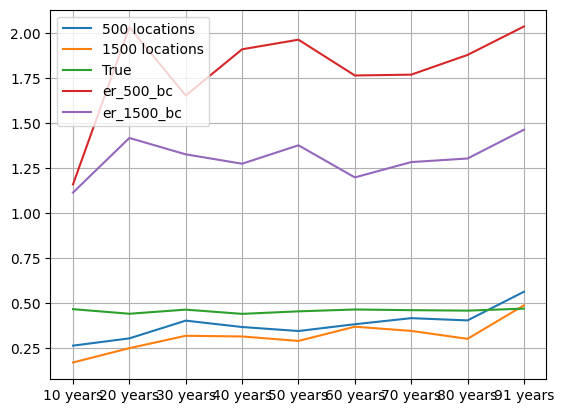

In [16]:
plt.plot(abs_er500,label='500 locations')
plt.plot(abs_er1500,label ='1500 locations')
plt.plot(abs_erfor,label='True')
plt.plot(er500loc_act.abs().mean(axis=0),label='er_500_bc')
plt.plot(er1500loc_act.abs().mean(axis=0),label='er_1500_bc')
plt.legend()
plt.grid()

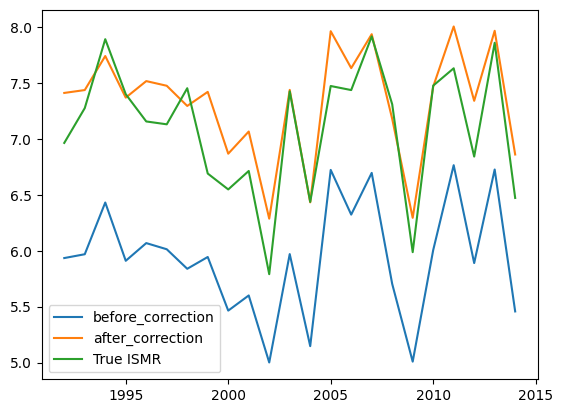

In [17]:
plt.plot(range(1992,2015),df500loc_bc['10 years'],label='before_correction')
plt.plot(range(1992,2015),df500loc_ac['10 years'],label='after_correction')
plt.plot(range(1992,2015),df_true_forecasting['10 years'],label='True ISMR')
plt.legend()

In [18]:
df500loc_bc.to_csv('error_correction_Data_Xgb/spa_estimation_500_locations_bc_Xgboost',float_format='%.8f')
df800loc_bc.to_csv('error_correction_Data_Xgb/spa_estimation_800_locations_bc_Xgboost',float_format='%.8f')
df1000loc_bc.to_csv('error_correction_Data_Xgb/spa_estimation_1000_locations_bc_Xgboost',float_format='%.8f')
df1500loc_bc.to_csv('error_correction_Data_Xgb/spa_estimation_1500_locations_bc_Xgboost',float_format='%.8f')

df500loc_ac.to_csv('error_correction_Data_Xgb/spa_estimation_500_locations_ac_Xgboost',float_format='%.8f')
df800loc_ac.to_csv('error_correction_Data_Xgb/spa_estimation_800_locations_ac_Xboost',float_format='%.8f')
df1000loc_ac.to_csv('error_correction_Data_Xgb/spa_estimation_1000_locations_ac_Xboost',float_format='%.8f')
df1500loc_ac.to_csv('error_correction_Data_Xgb/spa_estimation_1500_locations_ac_Xgboost',float_format='%.8f')

df_true_forecasting.to_csv('error_correction_Data_Xgb/True_ISMR_entire_set_Xgboost',float_format='%.8f')
df_predicted_forecasting.to_csv('error_correction_Data_Xgb/Prediction_through_entire_set_Xgboost',float_format='%.8f')

er500loc_act.to_csv('error_correction_Data_Xgb/error_actual_500_locations_9214_Xgboost',float_format='%.8f')
er800loc_act.to_csv('error_correction_Data_Xgb/error_actual_800_locations_9214_Xgboost',float_format='%.8f')
er1000loc_act.to_csv('error_correction_Data_Xgb/error_actual_1000_locations_9214_Xgboost',float_format='%.8f')
er1500loc_act.to_csv('error_correction_Data_Xgb/error_actual_1500_locations_9214_Xgboost',float_format='%.8f')

er500loc_pred.to_csv('error_correction_Data_Xgb/error_predicted_500_locations_9214_Xgboost',float_format='%.8f')
er800loc_pred.to_csv('error_correction_Data_Xgb/error_predicted_800_locations_9214_Xgboost',float_format='%.8f')
er1000loc_pred.to_csv('error_correction_Data_Xgb/error_predicted_1000_locations_9214_Xgboost',float_format='%.8f')
er1500loc_pred.to_csv('error_correction_Data_Xgb/error_predicted_1500_locations_9214_Xgboost',float_format='%.8f') 